In [9]:
import pandas as pd
df = pd.read_csv(r'C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga.csv')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,node_158,node_159,"Udmurts,Besermyan","Udmurts,Besermyan",44.22830,5,11.81180
1,node_158,node_160,"Udmurts,Besermyan","Udmurts,Besermyan",32.09880,4,11.42640
2,node_158,node_161,"Udmurts,Besermyan","Udmurts,Besermyan",51.91020,6,10.48110
3,node_158,node_162,"Udmurts,Besermyan","Udmurts,Besermyan",35.44570,3,13.15160
4,node_158,node_163,"Udmurts,Besermyan","Udmurts,Besermyan",24.03060,2,16.08090
...,...,...,...,...,...,...,...
169374,node_16079,node_16098,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",Chuvash,10.51550,1,10.51550
169375,node_16079,node_16100,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",27.97480,2,21.79260
169376,node_16082,node_16086,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",28.95360,2,18.24450
169377,node_16086,node_16089,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",8.47385,1,8.47385


In [11]:
df[['node_id1', 'node_id2']].to_csv('volga.edges', index=None, header=None)

# Libs

In [1]:
import pandas as pd
import importlib
import torch
import numpy as np
import random
import sys
import os.path
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
# import ancinf.utils.genlink
# importlib.reload(ancinf.utils.genlink)
from ancinf.utils.genlink import DataProcessor, NullSimulator, Trainer, TAGConv_3l_128h_w_k3, TAGConv_3l_512h_w_k3

# Null simulations

In [2]:
cross_class_prob = 3.41394026e-03

cross_class_probs = [(cross_class_prob + coeff) for coeff in np.linspace(start=3.41394026e-03 / 2, stop=0.1, num=10)]

res = []

for tmp_cross_class_prob in cross_class_probs:

#     probs = np.array([[2.77715566e-01, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
#     weights = np.array([[14.90908489,  1.94265021], [1.94265021, 12.70004896]])
    probs = np.array([[5.02849789e-02, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
    weights = np.array([[1.94265021,  1.94265021], [1.94265021, 1.94265021]])
    
    ns = NullSimulator(2, probs, weights) # use first two classes of NC dataset as background

    means, counts, pop_index = ns.generate_matrices([300]*2)

    ns.simulate_graph(means, counts, pop_index, "/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_100.csv")

    dp = DataProcessor("/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_100.csv")

    dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

    dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

    trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1.]).to('cuda'), 10, "runs/nc_null", 2, 20)

    res.append(trainer.run())



n_pops=2
(2, 2, 300, 300)
[[  0.         579.           0.           0.           8.36098055]
 [  1.         580.           0.           0.           9.5819249 ]
 [  2.         581.           0.           0.           8.90429009]
 ...
 [578.         520.           1.           1.          11.97910813]
 [578.         535.           1.           1.           8.90007335]
 [578.         545.           1.           1.          11.66528916]] 238


Make test samples: 100%|██████████| 118/118 [00:00<00:00, 238.43it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'runs/nc_null'

In [9]:
from numba import njit
@njit(cache=True)
def drop_rows_for_training_dataset(df, test_nodes):
    drop_rows = []
    for i in range(df.shape[0]):  # speed it up in future
        row = df[i, :]
        if int(row[0]) in test_nodes or int(row[1]) in test_nodes:
            drop_rows.append(i)

    return drop_rows

drop_rows_for_training_dataset(np.ones((10, 5)), np.array([1., 1., 1., 1., 1.]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
cross_class_probs

[0.00682788052,
 0.11644855382444444,
 0.22606922712888888,
 0.33568990043333335,
 0.4453105737377778,
 0.5549312470422222,
 0.6645519203466665,
 0.774172593651111,
 0.8837932669555555,
 0.99341394026]

In [22]:
res

[1.0, 0.9745744451626804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [20]:
print(max(cross_class_probs), min(cross_class_probs), len(cross_class_probs))

0.99341394026 0.00512091039 100


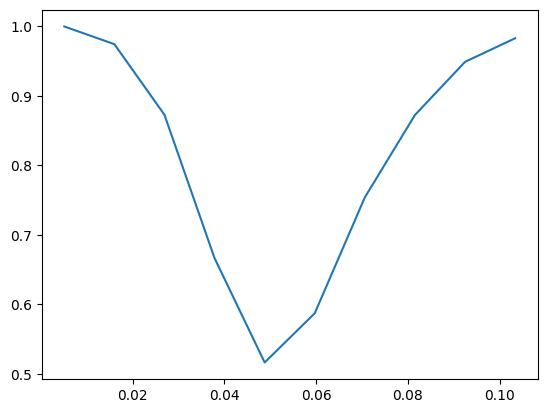

In [25]:
import matplotlib.pyplot as plt
plt.plot(cross_class_probs, res)


In [22]:
ns.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [23]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [24]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [25]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 191:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated test node found! Restart with different seed or this node will be ignored.


In [26]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\nc_null", 10, 20)

Compute metrics:   0%|                                                                          | 0/40 [00:00<?, ?it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.00it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

f1 macro improvement to 1.0



Training samples: 100%|████████████████████████████████████████████| 122/122 [00:03<00:00, 32.83it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 272.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 115.78it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 246.78it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.28it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 265.75it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 3th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 117.21it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 216.65it/s]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122





Training samples:  10%|████▎                                       | 12/122 [00:00<00:00, 114.00it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 4th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 112.73it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 263.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 5th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.86it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 264.24it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 6th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.63it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 261.40it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 7th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 118.57it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 275.84it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 8th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.14it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 274.11it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 9th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.41it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 260.48it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 10th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.19it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 264.46it/s]


Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

f1 macro score on test dataset: 1.0


<Figure size 640x480 with 0 Axes>

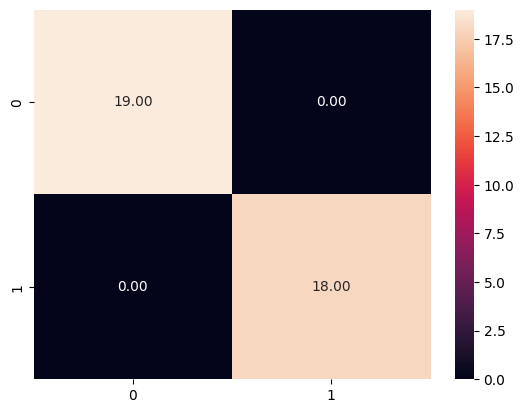

In [27]:
trainer.run()

# NC simulations

In [10]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\nc\raw\NC_graph_rel.csv")
# dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv")

In [11]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [12]:
dp.compute_simulation_params()

C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
dp.edge_probs

array([[2.77715566e-01, 3.41394026e-03, 5.38555692e-03, 1.31174089e-01,
        6.12725844e-03, 1.15384615e-02, 1.52046784e-02, 1.08892922e-03],
       [3.41394026e-03, 5.02849789e-02, 2.24701446e-02, 7.92619543e-03,
        2.01694232e-04, 1.66320166e-02, 7.50750751e-04, 5.12581547e-03],
       [5.38555692e-03, 2.24701446e-02, 3.61696306e-01, 1.31932021e-02,
        2.60326276e-04, 3.89087657e-02, 5.81395349e-03, 9.22213312e-03],
       [1.31174089e-01, 7.92619543e-03, 1.31932021e-02, 4.75113122e-01,
        2.58323766e-03, 7.10059172e-02, 5.34188034e-03, 1.32625995e-03],
       [6.12725844e-03, 2.01694232e-04, 2.60326276e-04, 2.58323766e-03,
        3.28831474e-02, 1.14810563e-03, 4.14593698e-04, 2.57334020e-04],
       [1.15384615e-02, 1.66320166e-02, 3.89087657e-02, 7.10059172e-02,
        1.14810563e-03, 2.28506787e-01, 2.13675214e-03, 4.64190981e-03],
       [1.52046784e-02, 7.50750751e-04, 5.81395349e-03, 5.34188034e-03,
        4.14593698e-04, 2.13675214e-03, 1.58333333e-01, 0.

In [14]:
dp.mean_weight

array([[14.90908489,  1.94265021,  2.30568932,  7.77972619,  2.61010051,
         2.93902175,  1.65329692,  2.14949   ],
       [ 1.94265021, 12.70004896,  3.5279301 ,  3.07051311,  1.3875125 ,
         3.66120656,  0.867145  ,  1.32968409],
       [ 2.30568932,  3.5279301 , 31.37447639,  2.85508017,  2.20767333,
         4.03104862,  1.64853889,  4.05216522],
       [ 7.77972619,  3.07051311,  2.85508017, 19.63135611,  1.25224833,
         4.60230609,  1.91038   ,  5.65972   ],
       [ 2.61010051,  1.3875125 ,  2.20767333,  1.25224833, 36.52264036,
         4.34636875,  3.7234    ,  2.2861    ],
       [ 2.93902175,  3.66120656,  4.03104862,  4.60230609,  4.34636875,
        13.66507809,  3.84755   ,  1.68632286],
       [ 1.65329692,  0.867145  ,  1.64853889,  1.91038   ,  3.7234    ,
         3.84755   , 12.48511053, -8.        ],
       [ 2.14949   ,  1.32968409,  4.05216522,  5.65972   ,  2.2861    ,
         1.68632286, -8.        , 17.22307933]])

In [11]:
means, counts, pop_index = dp.generate_matrices([500]*3)

n_pops=3
(3, 3, 500, 500)
pop_i=0 pop_j=0
total_segments=15128
pop_i=1 pop_j=0
total_segments=2774
pop_i=1 pop_j=1
total_segments=19160
pop_i=2 pop_j=0
total_segments=340
pop_i=2 pop_j=1
total_segments=788
pop_i=2 pop_j=2
total_segments=7304


In [12]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [13]:
import numpy as np
check_symmetric(counts)

True

In [7]:
print(counts.shape)

(800, 800)


In [16]:
dp.classes

['Swedes', 'Norwegians', 'Danes']

In [14]:
dp.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\data\generated_sc\raw\simulated_sc_500.csv")

In [17]:
for i in range(3500, 4000):
    print(G.nodes[i]['y'])

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [11]:
dp.edge_probs.round(2)

array([[0.28, 0.  , 0.01, 0.13, 0.01, 0.01, 0.02, 0.  ],
       [0.  , 0.05, 0.02, 0.01, 0.  , 0.02, 0.  , 0.01],
       [0.01, 0.02, 0.36, 0.01, 0.  , 0.04, 0.01, 0.01],
       [0.13, 0.01, 0.01, 0.48, 0.  , 0.07, 0.01, 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.01, 0.02, 0.04, 0.07, 0.  , 0.23, 0.  , 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.16, 0.  ],
       [0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.11]])

In [7]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [11]:
pop_index

array([0, 0, 0, ..., 7, 7, 7])

In [6]:
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\data\generated_we\raw\simulated_we.csv", sep=',')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum
0,node_19,node_7,English,English,10.098513
1,node_28,node_14,English,English,17.500695
2,node_29,node_0,English,English,10.148421
3,node_30,node_1,English,English,12.850058
4,node_30,node_22,English,English,8.544812
...,...,...,...,...,...
6091,node_1999,node_1865,Belgium,Belgium,12.662206
6092,node_1999,node_1886,Belgium,Belgium,31.445615
6093,node_1999,node_1887,Belgium,Belgium,9.249153
6094,node_1999,node_1905,Belgium,Belgium,10.947118


In [7]:
df[df.node_id2=='node_0'].label_id2.unique()

array(['English'], dtype=object)

In [11]:
df[((df.label_id1 == 'чеченцы') & (df.label_id2 == 'кабардинцы,черкесы,адыгейцы')) | ((df.label_id1 == 'кабардинцы,черкесы,адыгейцы') & (df.label_id2 == 'чеченцы'))].ibd_sum.mean()

10.094627886661257

In [9]:
df[(df.label_id1 == 'English') & (df.label_id2 == 'English')].ibd_sum.mean()

11.176547184133804

In [50]:
(np.random.default_rng().exponential(scale=4, size=1000)+20).mean()

23.869373102413423

# WE

In [2]:
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe_weights_partial_labels.csv")
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga_weights_partial_labels.csv")
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia_weights_partial_labels.csv")
df

,node_id1,node_id2,ibd_sum,ibd_n,ibd_max,label_id1,label_id2
0,node_2,node_1829,9.50609,1,9.50609,Estonians,Swedes
1,node_2,node_1837,9.29771,1,9.29771,Estonians,Swedes
2,node_2,node_8869,10.65770,1,10.65770,Estonians,Swedes
3,node_2,node_8891,8.23524,1,8.23524,Estonians,Swedes
4,node_2,node_11641,13.71090,1,13.71090,Estonians,Swedes
...,...,...,...,...,...,...,...
33201,node_11652,node_15314,9.14623,1,9.14623,Swedes,Russians
33202,node_11653,node_13240,8.59061,1,8.59061,Swedes,Russians
33203,node_11653,node_12704,8.69799,1,8.69799,Swedes,"Karelians,Veps"
33204,node_11653,node_12737,11.75780,1,11.75780,Swedes,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens"


In [3]:
df.label_id1.unique()

array(['Estonians', 'Poles', 'Dolgans,Yakuts', 'Kazakhs',
       'Udmurts,Besermyan', 'Uzbeks',
       'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Ket', 'Mordvins',
       'Bashkirs', 'Kabardians,Cherkess,Adygeans', 'Kyrgyz',
       'Karelians,Veps', 'Belarusians', 'Ukrainians', 'Chuvash', 'Komi',
       'Moldovans', 'Evenks', 'Ashkenazim', 'English', 'Swedes', 'Roma',
       'Basques', 'Balkan', 'Germans', 'Armenians,Hemshins', 'French',
       'Finns', 'Sephardim', 'Scots', 'Puerto-Ricans', 'Spaniards',
       'Tamils', 'Pashtuns', 'Khanty,Mansi', 'Albanians,Greeks',
       'Mexicans', 'Norwegians', 'Ossetians', 'Lithuanians', 'Sami',
       'Czechs,Slovaks', 'Danes', 'Tuscans', 'Belgium'], dtype=object)

In [24]:
df.ibd_sum.min()

8.00001

In [5]:
# df = df[['node_id1','node_id2','label_id1','label_id2','ibd_sum','ibd_n','ibd_max']]
# df

In [4]:
selected_rows = []
# sel_pop = ['English', 'Germans', 'French', 'Belgium']
# sel_pop = ['Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Chuvash', 'Udmurts,Besermyan', 'Mari']
sel_pop = ['Norwegians', 'Swedes', 'Danes']

for i in range(df.shape[0]):
    row = df.iloc[i, 5:]
    if row[0] in sel_pop and row[1] in sel_pop:
        selected_rows.append(True)
    else:
        selected_rows.append(False)

In [6]:
df_mod = df[selected_rows][['node_id1', 'node_id2', 'label_id1', 'label_id2',  'ibd_sum', 'ibd_n', 'ibd_max']]
df_mod

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
498,node_1799,node_1821,Swedes,Swedes,18.25960,1,18.25960
499,node_1799,node_1841,Swedes,Swedes,8.35242,1,8.35242
500,node_1799,node_1867,Swedes,Swedes,9.57823,1,9.57823
523,node_1799,node_8828,Swedes,Swedes,11.78040,1,11.78040
524,node_1799,node_8832,Swedes,Swedes,11.22940,1,11.22940
...,...,...,...,...,...,...,...
33170,node_11643,node_11647,Swedes,Swedes,10.38140,1,10.38140
33171,node_11643,node_11648,Swedes,Swedes,10.26240,1,10.26240
33175,node_11645,node_11651,Swedes,Swedes,10.72090,1,10.72090
33180,node_11646,node_11651,Swedes,Swedes,15.19660,2,8.40791


In [7]:
df_mod.to_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv", index=False)

# runs

In [84]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [85]:
set_global_seed(42)

In [12]:
# torch.load(r"C:\HSE\genotek-nationality-analysis\data\mapping_indices.pt")

In [2]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe.csv")

In [3]:
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,0,76,0,0,10.65130,1,10.65130
1,0,85,0,0,8.51599,1,8.51599
2,0,119,0,0,11.50810,1,11.50810
3,0,371,0,0,14.50930,1,14.50930
4,0,704,0,0,9.06940,1,9.06940
...,...,...,...,...,...,...,...
22041,3395,3472,5,5,8.15428,1,8.15428
22042,3396,3846,5,5,8.40182,1,8.40182
22043,3397,3888,5,5,8.17397,1,8.17397
22044,3398,3886,5,5,9.03886,1,9.03886


In [4]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [88]:
nc.load_train_valid_test_nodes(r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\train_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\val_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\test_indices.pt",
                              'torch')

In [6]:
import numpy as np
tmp_df = nc.node_classes_sorted.loc[nc.node_classes_sorted['node'].isin(nc.valid_nodes)]
np.unique(tmp_df['class_id'].to_numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([19, 29, 17, 10, 26, 10,  3,  5], dtype=int64))

In [21]:
nc.train_nodes

[0,
 2,
 3,
 5,
 6,
 7,
 9,
 13,
 17,
 18,
 19,
 20,
 22,
 29,
 30,
 31,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 78,
 79,
 81,
 84,
 86,
 87,
 88,
 92,
 93,
 96,
 100,
 102,
 104,
 105,
 106,
 110,
 111,
 112,
 113,
 114,
 115,
 119,
 122,
 124,
 125,
 127,
 128,
 130,
 132,
 133,
 138,
 139,
 140,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 163,
 166,
 167,
 168,
 170,
 171,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 186,
 188,
 190,
 193,
 194,
 195,
 197,
 198,
 199,
 200,
 203,
 204,
 205,
 209,
 211,
 213,
 216,
 217,
 218,
 219,
 220,
 223,
 224,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 236,
 237,
 238,
 243,
 244,
 245,
 247,
 249,
 250,
 252,
 253,
 254,
 258,
 259,
 261,
 262,
 263,
 265,
 266,
 268,
 269,
 270,
 274,
 275,
 277,
 278,
 279,
 280,
 282,
 283,
 285,
 287,
 290,
 291,
 294,
 296,
 297,
 298,
 299,
 3

In [5]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'we_my_random')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 181:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:   8%|████▊                                                        | 62/791 [00:00<00:08, 83.98it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  14%|████████▏                                                   | 108/791 [00:01<00:07, 86.39it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  16%|█████████▌                                                  | 126/791 [00:01<00:07, 86.36it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  19%|███████████▌                                                | 153/791 [00:01<00:07, 83.81it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  22%|████████████▉                                               | 171/791 [00:02<00:07, 82.57it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  29%|█████████████████▋                                          | 233/791 [00:02<00:06, 86.64it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  34%|████████████████████▍                                       | 270/791 [00:03<00:06, 83.17it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  36%|█████████████████████▊                                      | 288/791 [00:03<00:06, 83.12it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  40%|███████████████████████▉                                    | 315/791 [00:03<00:05, 84.48it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  43%|█████████████████████████▉                                  | 342/791 [00:04<00:05, 81.44it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  47%|███████████████████████████▉                                | 369/791 [00:04<00:05, 81.05it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  52%|███████████████████████████████▎                            | 413/791 [00:05<00:04, 80.46it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  55%|█████████████████████████████████▎                          | 439/791 [00:05<00:04, 81.34it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  61%|████████████████████████████████████▌                       | 482/791 [00:05<00:03, 80.99it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  67%|████████████████████████████████████████                    | 528/791 [00:06<00:03, 86.50it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  70%|██████████████████████████████████████████                  | 555/791 [00:06<00:02, 82.77it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  75%|████████████████████████████████████████████▊               | 591/791 [00:07<00:02, 80.45it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  85%|███████████████████████████████████████████████████▏        | 674/791 [00:08<00:01, 81.03it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  92%|███████████████████████████████████████████████████████     | 726/791 [00:08<00:00, 79.95it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  97%|██████████████████████████████████████████████████████████▎ | 769/791 [00:09<00:00, 80.32it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples: 100%|████████████████████████████████████████████████████████████| 791/791 [00:09<00:00, 81.38it/s]


Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make test samples:   2%|█▍                                                            | 18/788 [00:00<00:09, 81.47it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:   8%|████▊                                                         | 61/788 [00:00<00:08, 80.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  13%|████████▏                                                    | 105/788 [00:01<00:08, 83.30it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  18%|██████████▉                                                  | 142/788 [00:01<00:07, 86.74it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  24%|██████████████▋                                              | 189/788 [00:02<00:06, 88.59it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.



Make test samples:  25%|███████████████▍                                             | 199/788 [00:02<00:06, 90.02it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  32%|███████████████████▋                                         | 254/788 [00:03<00:06, 85.39it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  35%|█████████████████████                                        | 272/788 [00:03<00:06, 83.32it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  40%|████████████████████████▌                                    | 317/788 [00:03<00:05, 80.67it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  43%|██████████████████████████                                   | 336/788 [00:04<00:05, 84.13it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  45%|███████████████████████████▍                                 | 354/788 [00:04<00:05, 82.14it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  48%|█████████████████████████████▍                               | 381/788 [00:04<00:04, 81.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  52%|███████████████████████████████▋                             | 409/788 [00:04<00:04, 83.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  55%|█████████████████████████████████▊                           | 436/788 [00:05<00:04, 83.96it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  60%|████████████████████████████████████▌                        | 472/788 [00:05<00:03, 83.82it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  63%|██████████████████████████████████████▋                      | 499/788 [00:06<00:03, 81.46it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  66%|████████████████████████████████████████▏                    | 519/788 [00:06<00:03, 84.72it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  68%|█████████████████████████████████████████▌                   | 537/788 [00:06<00:03, 83.29it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  74%|█████████████████████████████████████████████                | 582/788 [00:07<00:02, 81.43it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  78%|███████████████████████████████████████████████▍             | 612/788 [00:07<00:01, 90.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  81%|█████████████████████████████████████████████████▌           | 640/788 [00:07<00:01, 83.57it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  86%|████████████████████████████████████████████████████▎        | 676/788 [00:08<00:01, 82.93it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  89%|██████████████████████████████████████████████████████▍      | 703/788 [00:08<00:01, 83.06it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  95%|█████████████████████████████████████████████████████████▉   | 748/788 [00:09<00:00, 80.56it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  97%|███████████████████████████████████████████████████████████▎ | 766/788 [00:09<00:00, 83.36it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|█████████████████████████████████████████████████████████████| 788/788 [00:09<00:00, 82.79it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


In [7]:
torch.sum(nc.array_of_graphs_for_testing[10].x != 1.)

tensor(2705)

In [6]:
nc.array_of_graphs_for_testing[10].x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.1250, 0.1250, 0.1250,  ..., 0.1250, 0.1250, 0.1250]],
       dtype=torch.float64)

In [7]:
nc.classes

['карачаевцы,балкарцы',
 'осетины',
 'кабардинцы,черкесы,адыгейцы',
 'ингуши',
 'кумыки',
 'ногайцы',
 'чеченцы',
 'дагестанские народы']

In [11]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1., 2., 100., 100., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\we\my_random", 10, 20)

Compute metrics:   0%|▏                                                                | 2/754 [00:00<00:38, 19.66it/s]

Training for data: we_my_random



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:03<00:00, 242.54it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.64      0.51      0.57       136
           2       0.20      0.15      0.18        78
           3       0.00      0.00      0.00         5
           4       0.00      0.17      0.00         6
           5       0.65      1.00      0.79        68

    accuracy                           0.20       754
   macro avg       0.25      0.31      0.26       754
weighted avg       0.19      0.20      0.19       754

f1 macro improvement to 0.2565239752308907



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 118.71it/s, val_best_score=0.257]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.257]

Compute metrics:  89%|█████████████████████████████████████████████████████▌      | 2124/2379 [00:08<00:00, 263.57it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.60it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.75it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

f1 macro improvement to 0.6144679690620096



Training samples:  71%|██████████████████████████▎          | 1695/2379 [00:14<00:05, 119.36it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.53it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▉       | 2101/2379 [00:07<00:01, 267.45it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.62it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 267.02it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 1th time



Training samples:  72%|██████████████████████████▌          | 1708/2379 [00:14<00:05, 119.19it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.63it/s, val_best_score=0.614]

Compute metrics:  91%|██████████████████████████████████████████████████████▍     | 2156/2379 [00:08<00:00, 253.53it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.00it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 268.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 2th time



Training samples:  71%|██████████████████████████           | 1679/2379 [00:14<00:05, 118.69it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.53it/s, val_best_score=0.614]

Compute metrics:  86%|███████████████████████████████████████████████████▎        | 2035/2379 [00:07<00:01, 272.32it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 260.79it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 259.49it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 3th time



Training samples:  71%|██████████████████████████▎          | 1692/2379 [00:14<00:05, 117.54it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.614]

Compute metrics:  89%|█████████████████████████████████████████████████████▍      | 2117/2379 [00:07<00:00, 265.94it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 265.06it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.21it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 4th time



Training samples:  70%|█████████████████████████▊           | 1663/2379 [00:14<00:06, 117.89it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.88it/s, val_best_score=0.614]

Compute metrics:  86%|███████████████████████████████████████████████████▊        | 2054/2379 [00:07<00:01, 263.99it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.36it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 5th time



Training samples:  71%|██████████████████████████▏          | 1687/2379 [00:14<00:05, 120.26it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.19it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▍       | 2079/2379 [00:07<00:01, 271.60it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 261.14it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 6th time



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 120.16it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.92it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▏       | 2069/2379 [00:07<00:01, 270.71it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 257.83it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 7th time



Training samples:  71%|██████████████████████████▏          | 1683/2379 [00:14<00:05, 120.20it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.46it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▉       | 2101/2379 [00:08<00:01, 264.93it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.05it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.99it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 8th time



Training samples:  71%|██████████████████████████▏          | 1685/2379 [00:14<00:05, 120.29it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.14it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▍       | 2081/2379 [00:07<00:01, 254.42it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.30it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.38it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 9th time



Training samples:  71%|██████████████████████████▏          | 1682/2379 [00:14<00:05, 119.83it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.37it/s, val_best_score=0.614]

Compute metrics:  89%|█████████████████████████████████████████████████████▍      | 2117/2379 [00:08<00:00, 262.25it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.56it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.72it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 10th time



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 117.20it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.09it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▌       | 2082/2379 [00:07<00:01, 257.70it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 735/735 [00:02<00:00, 264.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Test report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       458
           1       0.94      0.94      0.94       127
           2       0.88      0.74      0.80        72
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         6
           5       0.96      0.96      0.96        68

    accuracy                           0.95       735
   macro avg       0.62      0.61      0.61       735
weighted avg       0.93      0.95      0.94       735

f1 macro score on test dataset: 0.6125904502999738


<Figure size 640x480 with 0 Axes>

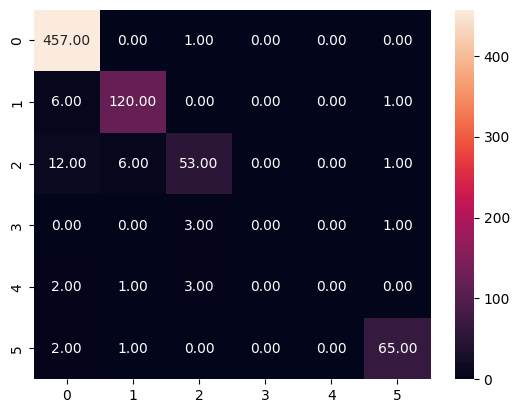

In [12]:
trainer.run()

In [13]:
dp.classes

['English', 'Germans', 'French', 'Spaniards', 'Tuscans', 'Belgium']

In [7]:
len(nc.valid_nodes)

123

In [8]:
len(nc.array_of_graphs_for_validation)

119

In [39]:
cr.node_classes_sorted

,node,class_id
0,0,0
23,1,0
45,2,0
61,3,0
74,4,0
...,...,...
14467,3762,1
14492,3763,2
16500,3764,1
21116,3765,2


In [48]:
from sklearn.metrics import f1_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='weighted', labels=[0])

0.8

In [1]:
type([])

list

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6



# tmp

In [20]:
import networkx as nx

In [21]:
G = nx.Graph()
G.add_edge(0, 1, pop_index_1='a', pop_index_2='b', weigth=1)
G.add_edge(0, 2, pop_index_1='a', pop_index_2='c', weigth=2)
G.add_edge(0, 3, pop_index_1='a', pop_index_2='d', weigth=3)
nx.write_edgelist(G, 'tmp.csv', data=['pop_index_1', 'pop_index_2', 'weigth'])

In [23]:
G.nodes

NodeView((0, 1, 2, 3))

In [22]:
pd.read_csv('tmp.csv', header=None, sep=' ')

,0,1,2,3,4
0,0,1,a,b,1
1,0,2,a,c,2
2,0,3,a,d,3
